## 📊 Dataset Overview
This project uses three anonymized datasets representing real-world customer profiles, credit bureau information, and transaction patterns.
### **2️⃣ Credit Profile Dataset**
Contains financial and credit-worthiness indicators:
- `cust_id`
- `credit_score`
- `credit_utilisation`
- `outstanding_debt`
- `credit_inquiries_last_6_months`
- `credit_limit`

**Purpose:**
To evaluate customer risk, credit behavior, and credit eligibility.

In [12]:
from src.data_loader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
loader = DataLoader()
credit_profiles = loader.load_table("credit_profiles")

credit_profiles.head()

credit_profiles loaded successfully. shape: (1004, 6)


,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


## Handling Duplicate Records in `credit_profiles`

### Observation
The `credit_profiles` table contains 1004 records, while the `customers` table contains 1000 records.

Investigation shows 4 duplicate `cust_id` entries.
In each duplicate pair:

- The first record contains mostly missing values
- The second record contains complete credit information

### Business Reasoning
Since credit profile data is critical for risk assessment and eligibility evaluation, incomplete duplicate records should not be retained.

Keeping null-heavy records would distort credit analysis.

### Decision
For duplicate `cust_id` entries, we retain the last occurrence (complete record) and remove the earlier null record.


In [3]:
credit_profiles[credit_profiles["cust_id"].duplicated(keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [6]:
credit_profile = credit_profiles.drop_duplicates(subset = "cust_id", keep= "last")

In [8]:
credit_profile.shape

(1000, 6)

In [9]:
credit_profile.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

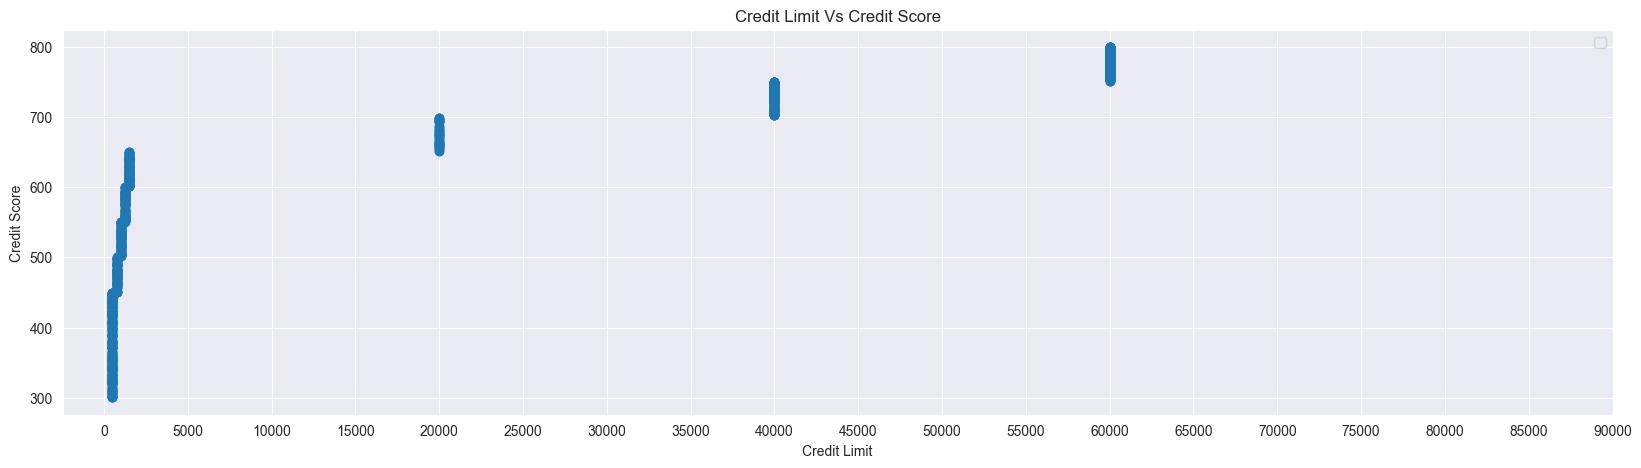

In [13]:
plt.figure(figsize=(20,5))
plt.scatter(credit_profile.credit_limit, credit_profile.credit_score)
plt.xlabel("Credit Limit")
plt.ylabel("Credit Score")
plt.title("Credit Limit Vs Credit Score")
plt.xticks(range(0, 90001, 5000))
plt.grid(True)
plt.legend()
plt.show()

## Handling Missing Values in `credit_limit` Using Credit Score Segmentation

### Observation
The `credit_limit` column contains 65 missing values.

Credit limit allocation is closely associated with a customer's credit score. However, credit scores are continuous values, which makes structured analysis and imputation more complex.

### Business Reasoning
In real-world financial systems, credit limits are typically assigned based on credit score bands rather than exact numeric scores.

Segmenting customers into defined credit score ranges allows:

- Structured comparison of credit behavior
- Risk-based grouping aligned with lending policies
- More realistic and policy-consistent imputation

Using a global average would ignore risk segmentation and may distort credit exposure analysis.

### Decision
A new column `credit_score_range` is created by binning credit scores into defined ranges.

Missing `credit_limit` values are then imputed using the mode (most frequent value) within each `credit_score_range`, preserving consistency with lending behavior and maintaining realistic credit allocation patterns.


In [15]:
bins_range = [300, 450, 500, 550, 600, 650, 700, 750, 800]
bins_labels = [f"{start}-{end-1}" for start, end in zip(bins_range, bins_range[1:]) ]
bins_labels

['300-449',
 '450-499',
 '500-549',
 '550-599',
 '600-649',
 '650-699',
 '700-749',
 '750-799']

In [16]:
credit_profile["credit_score_range"] = pd.cut(credit_profile["credit_score"], bins= bins_range, labels= bins_labels, include_lowest= True, right=False)
credit_profile.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749


In [18]:
credit_limit_mode = credit_profile.groupby("credit_score_range")["credit_limit"].agg(lambda x: x.mode().iloc[0])
credit_limit_mode

credit_score_range
300-449      500.0
450-499      750.0
500-549     1000.0
550-599     1250.0
600-649     1500.0
650-699    20000.0
700-749    40000.0
750-799    60000.0
Name: credit_limit, dtype: float64

In [19]:
credit_profile["credit_limit"] =credit_profile.apply(
    lambda row:credit_limit_mode[row["credit_score_range"]] if pd.isnull(row["credit_limit"]) else row["credit_limit"],
    axis =1
)

In [20]:
credit_profile.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_range                0
dtype: int64

In [21]:
credit_profile.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.75000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.43818
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.00000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.00000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000


In [22]:
credit_profile[credit_profile.outstanding_debt > credit_profile.credit_limit].shape

(20, 7)

## Handling Inconsistent Values in `outstanding_debt`

### Observation
A total of 20 records show `outstanding_debt` greater than the assigned `credit_limit`.

In standard credit card operations, outstanding debt should not exceed the approved credit limit.

### Business Reasoning
Such inconsistencies likely indicate:

- Data entry errors
- Reporting mismatches
- System-level recording issues

If left uncorrected, these values may distort credit utilisation metrics and risk analysis.

### Decision
For the 20 affected records, `outstanding_debt` is capped at the corresponding `credit_limit` to maintain financial consistency and realistic credit exposure.


In [23]:
credit_profile.loc[credit_profile.outstanding_debt > credit_profile.credit_limit, "outstanding_debt"] = credit_profile["credit_limit"]

In [24]:
credit_profile[credit_profile.outstanding_debt > credit_profile.credit_limit].shape

(0, 7)

In [25]:
credit_profile.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,1250.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749
